Querying products:   1%|1         | 100/9784 [00:00<?, ?product/s]

MD5 checksumming:   0%|          | 0.00/969M [00:00<?, ?B/s]

{'id': 'ddcd6528-4d95-4b5f-9d45-940e1bdc5898',
 'title': 'S2A_MSIL2A_20230930T100811_N0509_R022_T31QEB_20230930T161159',
 'size': 968528887,
 'md5': '1b67370aae1a75fbe318e089a582a3b1',
 'date': datetime.datetime(2023, 9, 30, 10, 8, 11, 24000),
 'footprint': 'POLYGON((2.999808929625083 19.896427129850146,4.04871963465907 19.893337529015856,4.042382062848898 18.90120884301479,2.999810084547929 18.904132687386056,2.999808929625083 19.896427129850146))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('ddcd6528-4d95-4b5f-9d45-940e1bdc5898')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2023, 9, 30, 18, 1, 9, 738000),
 'Ingestion Date': datetime.datetime(2023, 9, 30, 18, 0, 51, 961000),
 'manifest_name': 'manifest.safe',
 'product_root_dir': 'S2A_MSIL2A_20230930T100811_N0509_R022_T31QEB_20230930T161159.SAFE',
 'quicklook_url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('ddcd6528-4d95-4b5f-9d45-940e1bdc5898')/Products('Quicklook')/$value",
 'path': 'S2A

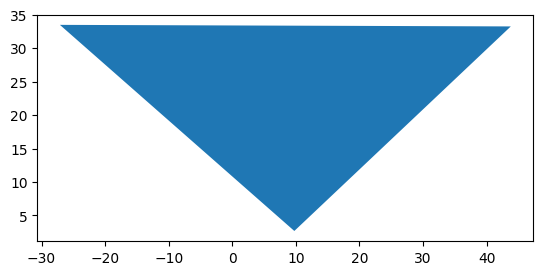

In [6]:
import geopandas as gpd
from sentinelsat import SentinelAPI

geojson_data = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [-27.121198187642506, 33.49399437616951],
            [9.752279625396056, 2.676966802956514],
            [43.80097125318781, 33.260692591966375],
            [-27.121198187642506, 33.49399437616951]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

triangle_gdf = gpd.GeoDataFrame.from_features(geojson_data["features"], crs="EPSG:4326")
triangle_gdf.plot()

api = SentinelAPI("cxq111", "DgT*t4BvUW!!#6.", "https://scihub.copernicus.eu/dhus")
aoi_wkt = triangle_gdf.geometry.to_wkt()[0]
products = api.query(area=aoi_wkt, date=("20230921", "20231001"), platformname="Sentinel-2")
product_id = list(products.keys())[0]
api.download(product_id)

In [4]:
pip install sentinelsat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 1.8 MB/s eta 0:00:00


In [8]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.9 MB/s eta 0:00:00


Raster bounds: BoundingBox(left=499980.0, bottom=2090220.0, right=609780.0, top=2200020.0)
Raster CRS: EPSG:32631
Converted Polygon bounds: [-2345945.31685985   297965.11737214  4414291.75087148  4533016.32463912]


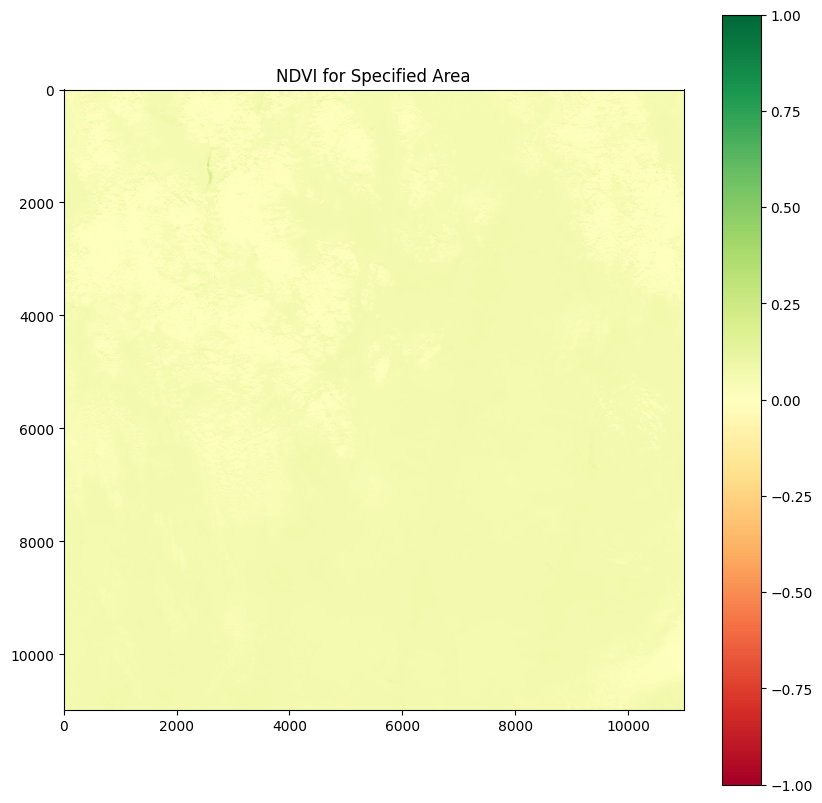

In [22]:
import geopandas as gpd
from sentinelsat import SentinelAPI
import rasterio
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt

base_path = "/content/unzipped_product/S2A_MSIL2A_20230930T100811_N0509_R022_T31QEB_20230930T161159.SAFE/GRANULE/L2A_T31QEB_A043205_20230930T101805/IMG_DATA/R10m/"

red_band_path = base_path + "T31QEB_20230930T100811_B04_10m.jp2"
nir_band_path = base_path + "T31QEB_20230930T100811_B08_10m.jp2"

with rasterio.open(red_band_path) as red_src:
    print("Raster bounds:", red_src.bounds)
    print("Raster CRS:", red_src.crs)

    triangle_gdf_projected = triangle_gdf.to_crs(red_src.crs)
    print("Converted Polygon bounds:", triangle_gdf_projected.total_bounds)

with rasterio.open(red_band_path) as red_src, rasterio.open(nir_band_path) as nir_src:
    red_data, red_transform = rasterio.mask.mask(red_src, triangle_gdf_projected.geometry, crop=True)
    nir_data, nir_transform = rasterio.mask.mask(nir_src, triangle_gdf_projected.geometry, crop=True)
    red_data = red_data[0].astype('float64')
    nir_data = nir_data[0].astype('float64')

ndvi = (nir_data - red_data) / (nir_data + red_data)

plt.figure(figsize=(10,10))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title('NDVI for Specified Area')
plt.show()